In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models


In [11]:
import numpy as np

# We know "None" corresponds to encoded class 2
RARE_CLASS_ID = 2

filtered_texts = []
filtered_labels = []

for t, lab in zip(texts, labels_encoded):
    if lab != RARE_CLASS_ID:  # drop the 'None' rows
        filtered_texts.append(t)
        filtered_labels.append(lab)

print("Original size:", len(texts))
print("Filtered size:", len(filtered_texts))

# Confirm remaining label distribution
print("\nRemaining label counts:")
print(pd.Series(filtered_labels).value_counts())


Original size: 318023
Filtered size: 318022

Remaining label counts:
0    106548
3    105831
1    105643
Name: count, dtype: int64


In [12]:
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    filtered_texts,
    filtered_labels,
    test_size=0.2,
    random_state=42,
    stratify=filtered_labels
)

print("Train size:", len(X_train_texts))
print("Test size :", len(X_test_texts))

# we'll reuse these hyperparams
MAX_VOCAB = 20000
MAX_LEN = 50
EMBED_DIM = 100


Train size: 254417
Test size : 63605


In [13]:
# We know original mapping from label_encoder.classes_:
# classes_ = ['Negative', 'Neutral', 'None', 'Positive']
# encoded :     0          1         2         3

# We'll remap {0,1,3} -> {0,1,2}
remap_dict = {0:0, 1:1, 3:2}

y_train = np.array([remap_dict[y] for y in y_train])
y_test  = np.array([remap_dict[y] for y in y_test])

num_classes = 3  # Negative, Neutral, Positive (clean)
print("Unique y_train after remap:", np.unique(y_train))
print("Unique y_test after remap :", np.unique(y_test))


Unique y_train after remap: [0 1 2]
Unique y_test after remap : [0 1 2]


In [14]:
class_names = ["Negative", "Neutral", "Positive"]
print("Class order for reporting:", class_names)


Class order for reporting: ['Negative', 'Neutral', 'Positive']


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq  = tokenizer.texts_to_sequences(X_test_texts)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')

print("Train padded shape:", X_train_pad.shape)
print("Test padded shape :", X_test_pad.shape)


Train padded shape: (254417, 50)
Test padded shape : (63605, 50)


In [16]:
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

embeddings_index = {}
with open("glove.6B.100d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Loaded word vectors:", len(embeddings_index))

word_index = tokenizer.word_index
vocab_size = min(MAX_VOCAB, len(word_index) + 1)

embedding_matrix = np.zeros((vocab_size, EMBED_DIM), dtype="float32")

for word, idx in word_index.items():
    if idx < MAX_VOCAB:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

print("Embedding matrix shape:", embedding_matrix.shape)


Loaded word vectors: 400000
Embedding matrix shape: (20000, 100)


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Embedding(
        input_dim=vocab_size,
        output_dim=EMBED_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False  # keep GloVe frozen
    ),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [18]:
history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    verbose=1
)


Epoch 1/5
3578/3578 ━━━━━━━━━━━━━━━━━━━━ 344s 95ms/step - accuracy: 0.5722 - loss: 0.9113 - val_accuracy: 0.6308 - val_loss: 0.8145
Epoch 2/5
3578/3578 ━━━━━━━━━━━━━━━━━━━━ 342s 96ms/step - accuracy: 0.6352 - loss: 0.8104 - val_accuracy: 0.6497 - val_loss: 0.7791
Epoch 3/5
3578/3578 ━━━━━━━━━━━━━━━━━━━━ 378s 95ms/step - accuracy: 0.6552 - loss: 0.7745 - val_accuracy: 0.6510 - val_loss: 0.7729
Epoch 4/5
3578/3578 ━━━━━━━━━━━━━━━━━━━━ 387s 96ms/step - accuracy: 0.6650 - loss: 0.7539 - val_accuracy: 0.6568 - val_loss: 0.7637
Epoch 5/5
3578/3578 ━━━━━━━━━━━━━━━━━━━━ 382s 96ms/step - accuracy: 0.6753 - loss: 0.7353 - val_accuracy: 0.6614 - val_loss: 0.7603


In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Predict
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy (GloVe + BiLSTM):", test_acc)

# Detailed report
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=class_names
))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


1988/1988 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step
Test Accuracy (GloVe + BiLSTM): 0.6583759138432513

Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.73      0.67     21310
     Neutral       0.60      0.64      0.62     21129
    Positive       0.79      0.61      0.69     21166

    accuracy                           0.66     63605
   macro avg       0.67      0.66      0.66     63605
weighted avg       0.67      0.66      0.66     63605

Confusion Matrix:
[[15512  4553  1245]
 [ 5561 13432  2136]
 [ 3757  4477 12932]]


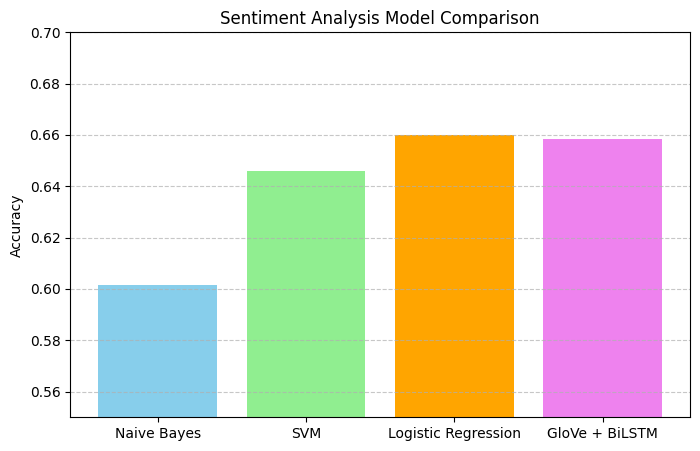

In [20]:
import matplotlib.pyplot as plt

models = ["Naive Bayes", "SVM", "Logistic Regression", "GloVe + BiLSTM"]
accuracies = [0.6015, 0.6459, 0.66, 0.6584]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'orange', 'violet'])
plt.title("Sentiment Analysis Model Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.55, 0.70)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
